Help on function savefig in module matplotlib.pyplot:

savefig(*args, **kwargs)
    Save the current figure.
    
    Call signature::
    
      savefig(fname, *, dpi='figure', format=None, metadata=None,
              bbox_inches=None, pad_inches=0.1,
              facecolor='auto', edgecolor='auto',
              backend=None, **kwargs
             )
    
    The available output formats depend on the backend being used.
    
    Parameters
    ----------
    fname : str or path-like or binary file-like
        A path, or a Python file-like object, or
        possibly some backend-dependent object such as
        `matplotlib.backends.backend_pdf.PdfPages`.
    
        If *format* is set, it determines the output format, and the file
        is saved as *fname*.  Note that *fname* is used verbatim, and there
        is no attempt to make the extension, if any, of *fname* match
        *format*, and no extension is appended.
    
        If *format* is not set, then the format is inf

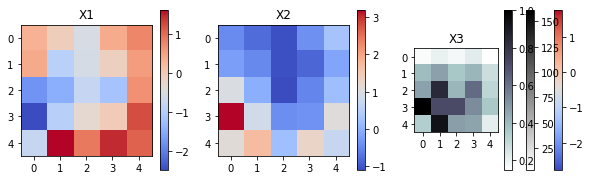

In [1]:
'''
通过指定性质，筛选分子，再进行拆分，寻找相似结构（扩充），合成新分子
实现分子自动进化寻优
优化目标暂定为 分子具备较好的SLOGP, 其次考虑可合成性sa score、类药性qed合适，用区间限定
类药性qed:越大越好。将药物相似性量化为介于0和1之间的数值
sa score:越靠近1表明越容易合成，越靠近10表明合成越困难。介于1和10之间
SLOGP:越靠近1.5的越安全，风险越小。（logP 0-3范围是最佳，高logP化合物水溶性差，低logP化合物脂渗透性差）

    # 容忍范围 {"QED":(0.8,1),"SAscore":(1,3),"SLOGP":(0,3)}
    # 理想目标{"QED":1,"SAscore":1,"SLOGP":1.5}

*** 引入概率、权重等更新进化思想
'''
import random
import numpy as np
import pandas as pd
from calc_logP_QED_sa import mol_properties
from fragments2mol import *
from test_fp_similarity import *
import time
from littlecode.tools.chouyang import chouyang
from littlecode.tools.mkdir import mkdir
from codes_for_manuscript_02.my_som_cluster import SOM_learner

root = "F:\\WORK\\和外合作\\天宇媛媛毕设\\"

In [40]:
# 校正smiles
def smiles_rewrite(smiles_list):
    smiles_list = read_mol(smiles_list,1)
    smiles_list = read_mol(smiles_list,0)
    return smiles_list

# smiles去重,不区分大小写
def quchong_smiles(smiles):
    unique_lst = []
    for s in smiles:
        if s not in unique_lst:
            unique_lst.append(s)
    return unique_lst


# 定义一个新指标，以其为优化目标（最小值，理想情况<1）
#  = 理想目标的欧氏距离，并考虑进容忍范围（超出容忍范围会显著增大指标>1）
def new_mertric(df):
    # df: dataframe 包含"QED", "SAscore", "SLOGP"
    QED, SAscore, SLOGP = (df[x].values for x in ["QED", "SAscore", "SLOGP"])
    df["new_mertric"] = np.sqrt(((QED-1)/0.2)**2+((SAscore-1)/2)**2+((SLOGP-1.5)/3)**2)
    return df


# 根据smiles计算properties：logP_QED_sa，再计算new_mertric
# 最好再排序筛选
class screen_smi:
    def __init__(self, smi_list):
        '''
        :param smi_list: list of smiles,或者已经计算了props的dataframe
        '''

        if type(smi_list) == list:
            self.smi_list = smi_list
            mols = {"SMILES":self.smi_list}
            a = mol_properties(mol_list=mols["SMILES"])
            mols["SLOGP"], mols["QED"], mols["SAscore"] = a.cal_SLOGP(), a.cal_qed(), a.cal_sa()
            mols = pd.DataFrame(mols)
            self.mols_prop = new_mertric(mols).sort_values(by="new_mertric")
        else:
            mols = smi_list[['SMILES','SLOGP','QED','SAscore','new_mertric']]
            self.mols_prop = new_mertric(mols).sort_values(by="new_mertric")

    def get_top_smi(self, select_n = 10):
        # 取前几名
        self.selected_mols = self.mols_prop[:select_n]
        return self.selected_mols["SMILES"].tolist()

    def get_screened_smi(self, max_new_mertric = 0.8):
        # 取所有<max_new_mertric
        self.selected_mols = self.mols_prop[self.mols_prop["new_mertric"] < max_new_mertric]
        return self.selected_mols["SMILES"].tolist()

    def save_prop(self, root = "F:\\WORK\\和外合作\\天宇媛媛毕设\\QSAR\\gen0"):
        # 只保存
        path = mkdir(root)
        try:
            self.selected_mols.to_csv(path+"\\selected_mols.csv", index=False)
        except:
            self.mols_prop.to_csv(path+"\\all_mol_props.csv", index=False)


def yichangchuli(smi_list):
    result = []
    for i in smi_list:
        try:
            i = eval(i)
            i = i[0]
        except:
            i = i
        result.append(i)

    return result

# 初始 多 种群获得
# 将备选的六百多个精英分子分别拆分、去重得到对应的骨架和碎片集，得到初始种群
def get_init_group(path = "F:\\WORK\\和外合作\\天宇媛媛毕设\\generate\\gen0\\", limit_length = 10):
    init_mols = pd.read_csv(path+"\\selected_mols.csv")
    init_mols_groups = init_mols["SMILES"].tolist()


    _, scaffords,_ ,_ = split_mol(init_mols_groups,'smiles',limit_length,10000,"[Fr]")
    _, decorations,_ ,_ = split_mol(init_mols_groups,'smiles',2,limit_length,"[Cs]")

    scaffords_groups = chouyang(scaffords, 5)
    decorations_groups = chouyang(decorations, 5)

    save_scaffords_groups_info = {i:[scaffords_groups[i]] for i in range(len(scaffords_groups))}
    save_decorations_groups_info = {i:[decorations_groups[i]] for i in range(len(decorations_groups))}
    save_scaffords_groups_info = pd.DataFrame(save_scaffords_groups_info)
    save_decorations_groups_info = pd.DataFrame(save_decorations_groups_info)
    save_scaffords_groups_info.to_csv(path+"\\init_scaffords_groups.csv")
    save_decorations_groups_info.to_csv(path+"\\init_decorations_groups.csv")

# 化学空间查询相似结构
def add_similar_frags(scaffords=[], decorations=[], select_n=5, root="F:\\WORK\\和外合作\\天宇媛媛毕设"):
    '''

    :param scaffords: smiles list with Fr
    :param decorations: smiles list with Cs
    :param select_n: 补加相似分子个数
    :param root: 主路径
    :return: 补加后的scaffords, decorations
    '''

    # 骨架
    if scaffords != []:
        # 补全分子
        scaffords_addH= []
        for item in scaffords:
            item = item.replace("Fr","H")
            scaffords_addH.append(item)
        # 计算fp
        scaffords_fp_cal = cal_fingerprint(scaffords_addH)
        scaffords_fp_cal.RDKitTopological(1024)
        scaffords_fp = scaffords_fp_cal.fp_TopoFingerprint.values
        # 读取SOM化学空间模型
        scaffords_model_path = root + "\\som化学空间\\Scaffold\\size20_sigma3_random_seed2023_model.p"

        scaffords_model = SOM_learner(dataset=scaffords_fp,trained_som=scaffords_model_path,size=20)
        scaffords_model.cluster_results()

        # 获取对应的cluster_index
        scaffords_id = scaffords_model.cluster_results_table["cluster_index"].tolist()

        # 查找相似结构
        Scaffold_space = pd.read_csv(root + "\\som化学空间\\Scaffold\\Scaffold_space.csv")

        # 逐个补充相似结构并去重
        new_scaffords,new_decorations = set(scaffords), set(decorations)
        for i in range(len(scaffords)):
            similar_scaffords = Scaffold_space[Scaffold_space["cluster_index"] == scaffords_id[i]]["frag_SMILES"].tolist()
            if len(similar_scaffords) == 0:
                continue

            try:
                add_scaffords = random.sample(similar_scaffords,select_n)
            except:
                add_scaffords = similar_scaffords

            new_scaffords.update(set(add_scaffords))
    else:
        new_scaffords = set([])

    # 修饰物
    if decorations != []:
        # 补全分子
        decorations_addH = []
        for item in decorations:
            item = item.replace("Cs","H")
            decorations_addH.append(item)
        # 计算fp
        decorations_fp_cal = cal_fingerprint(decorations_addH)
        decorations_fp_cal.RDKitTopological(1024)
        decorations_fp = decorations_fp_cal.fp_TopoFingerprint.values
        # 读取SOM化学空间模型
        decorations_model_path = root + "\\som化学空间\\decorations\\size10_sigma3_random_seed2023_model.p"

        decorations_model = SOM_learner(dataset=decorations_fp,trained_som=decorations_model_path,size=10)
        decorations_model.cluster_results()

        # 获取对应的cluster_index
        decorations_id = decorations_model.cluster_results_table["cluster_index"].tolist()
        # 查找相似结构
        decorations_space = pd.read_csv(root + "\\som化学空间\\decorations\\decorations_space.csv")
        # 逐个补充相似结构并去重
        new_decorations = set(decorations)
        for i in range(len(decorations)):
            similar_decorations = decorations_space[decorations_space["cluster_index"] == decorations_id[i]]["frag_SMILES"].tolist()
            try:
                add_decorations = random.sample(similar_decorations,select_n)
            except:
                add_decorations = similar_decorations

            new_decorations.update(set(add_decorations))
    else:
        new_decorations = set([])



    return list(new_scaffords), list(new_decorations)

# 碎片对应的化学空间查询
def frags_location(scaffords=[], decorations=[]):
    '''

    :param scaffords: smiles list with Fr
    :param decorations: smiles list with Cs
    :return: scaffords, decorations的cluster id 的list
    '''

    # 骨架
    if scaffords != []:
        # 补全分子
        scaffords_addH= []
        for item in scaffords:
            item = item.replace("Fr","H")
            scaffords_addH.append(item)
        # 计算fp
        scaffords_fp_cal = cal_fingerprint(scaffords_addH)
        scaffords_fp_cal.RDKitTopological(1024)
        scaffords_fp = scaffords_fp_cal.fp_TopoFingerprint.values
        # 读取SOM化学空间模型
        scaffords_model_path = root + "\\som化学空间\\Scaffold\\size20_sigma3_random_seed2023_model.p"

        scaffords_model = SOM_learner(dataset=scaffords_fp,trained_som=scaffords_model_path,size=20)
        scaffords_model.cluster_results()

        # 获取对应的cluster_index
        scaffords_id = scaffords_model.cluster_results_table["cluster_index"].tolist()

    else:
        scaffords_id = set([])

    # 修饰物
    if decorations != []:
        # 补全分子
        decorations_addH = []
        for item in decorations:
            item = item.replace("Cs","H")
            decorations_addH.append(item)
        # 计算fp
        decorations_fp_cal = cal_fingerprint(decorations_addH)
        decorations_fp_cal.RDKitTopological(1024)
        decorations_fp = decorations_fp_cal.fp_TopoFingerprint.values
        # 读取SOM化学空间模型
        decorations_model_path = root + "\\som化学空间\\decorations\\size10_sigma3_random_seed2023_model.p"

        decorations_model = SOM_learner(dataset=decorations_fp,trained_som=decorations_model_path,size=10)
        decorations_model.cluster_results()

        # 获取对应的cluster_index
        decorations_id = decorations_model.cluster_results_table["cluster_index"].tolist()
    else:
        decorations_id = set([])

    return list(scaffords_id), list(decorations_id)

# 按某代gen的碎片文件进行相似物扩充，保存当代
def smilar_frags_get(root, gen, neighborhood_n = 5):

    file1 = root + "generate\\gen" + str(gen) + "\\init_scaffords_groups.csv"
    file2 = root + "generate\\gen" + str(gen) + "\\init_decorations_groups.csv"
    init_scaffords = pd.read_csv(file1,index_col=0)
    init_decorations = pd.read_csv(file2,index_col=0)
    len_decorations = init_decorations.shape[1]
    len_scaffords = init_scaffords.shape[1]

    # 扩充骨架
    all_scaffords = set()
    for i in range(len_scaffords):
        scaffords01 = init_scaffords.iloc[0,i]
        scaffords1 = eval(scaffords01)

        new_scaffords,_ = add_similar_frags(scaffords=scaffords1,decorations=[],select_n=5)
        all_scaffords.update(new_scaffords)

    # 扩充修饰物
    all_decorations = set()
    for j in range(len_decorations):
        decorations01 = init_decorations.iloc[0,j]
        decorations1 = eval(decorations01)
        decorations1 = yichangchuli(decorations1)

        _, new_decorations1 = add_similar_frags(scaffords=[],decorations=decorations1,select_n=5)
        all_decorations.update(new_decorations1)

    all_scaffords, all_decorations = list(all_scaffords), list(all_decorations)

    scaffords_groups = chouyang(all_scaffords, neighborhood_n)
    decorations_groups = chouyang(all_decorations, neighborhood_n)

    save_scaffords_groups_info = {i:[scaffords_groups[i]] for i in range(len(scaffords_groups))}
    save_decorations_groups_info = {i:[decorations_groups[i]] for i in range(len(decorations_groups))}
    save_scaffords_groups_info = pd.DataFrame(save_scaffords_groups_info)
    save_decorations_groups_info = pd.DataFrame(save_decorations_groups_info)

    save_scaffords_groups_info.to_csv(root + "generate\\gen" + str(gen) + "\\similar_scaffords_groups.csv")
    save_decorations_groups_info.to_csv(root + "generate\\gen" + str(gen) + "\\similar_decorations_groups.csv")



In [3]:
# 进化框架
# 通过上一代总结的scaffords, decorations，
# 1，fully_decorated=0生成新的分子all_new_mols，计算指标，初步筛选scaffords, decorations，
# 2，然后用选好的再进行fully_decorated=1的生成，计算指标，筛选，保留最终的all_new_mols，list_all
# 3，最后，将list_all分子拆解为新一代的scaffords, decorations，
# 4，通过化学空间查询，加入部分相似scaffords, decorations，丰富结构
# 5，回到1
class run_evolution:
    def __init__(self, scaffords, decorations):
        self.scaffords = scaffords
        self.decorations = decorations

        # 1
        dict_new_mols_1, self.set_new_mols_1 = frag2mol_2(self.scaffords, self.decorations, fully_decorated=1)
        list_new_mols_1 = list(self.set_new_mols_1) # 生成分子的smiles list
        a1 = screen_smi(list_new_mols_1)
        list_screened_mols_1 = a1.get_screened_smi(0.8)
        self.set_screened_mols_1 =  set(list_screened_mols_1)# 以1为阈值，筛选合格分子
        # index_1 = [index for index, value in enumerate(list_new_mols_1) if value in self.list_screened_mols_1]


In [27]:
def run_for_hu(gen_no = 6):
    for gen_i in range(gen_no, 20):
        print(gen_i)
        ###########################基础生成#####################################
        # 计算基础
        gen = gen_i # 当前得到的新分子代，如果是偶数则计算全新分子，
        # 如果是奇数，计算相似碎片对应的新分子，用上一代偶数代的相似物统计文件

        #1 遍历运行，保存新指标<0.8
        save_path = mkdir(root + "generate\\gen" + str(gen+1))
        if (gen % 2) == 0:
            read_path = mkdir(root + "generate\\gen" + str(gen))
            init_scaffords = pd.read_csv(read_path + "\\" + "init_scaffords_groups.csv", index_col=0)
            init_decorations = pd.read_csv(read_path + "\\" +"init_decorations_groups.csv", index_col=0)
        else:
            read_path = mkdir(root + "generate\\gen" + str(gen-1))
            init_scaffords = pd.read_csv(read_path + "\\" + "similar_scaffords_groups.csv", index_col=0)
            init_decorations = pd.read_csv(read_path + "\\" +"similar_decorations_groups.csv", index_col=0)

        all_new_mols, all_screened_mols = set(),set()

        len_decorations = init_decorations.shape[1]
        len_scaffords = init_scaffords.shape[1]
        print("len_scaffords",len_scaffords)
        for i in range(0,len_scaffords):
            print(i)
            try:
                for j in range(len_decorations):

                    scaffords1, decorations1 = init_scaffords.iloc[0,i], init_decorations.iloc[0,j]
                    scaffords1, decorations1 = eval(scaffords1), eval(decorations1)
                    decorations1 = yichangchuli(decorations1)

                    decorations = set(decorations1)
                    decorations = list(decorations)
                    a = run_evolution(scaffords=scaffords1,decorations=decorations)

                    all_screened_mols.update(a.set_screened_mols_1)
                    all_new_mols.update(a.set_new_mols_1)
            except:
                pass

        all_screened_mols, all_new_mols = list(all_screened_mols), list(all_new_mols)
        # 保存这一代结果
        save_table1 = pd.DataFrame({"SMILES": all_screened_mols})
        save_table2 = pd.DataFrame({"all_new_mols": all_new_mols})
        save_table1.to_csv(save_path + "\\" + "selected_mols.csv")
        save_table2.to_csv(save_path + "\\" + "all_new_mols.csv")

        # 拆分碎片并保存作为下一代的运行基础
        # 如果得不到一条骨架，则缩小
        # 因为limit_length限制没有一个骨架，改写limit_length生成骨架
        for i in range(5,10):
            i = 15-i
            print(i)
            get_init_group(save_path, limit_length=i)
            init_scaffords = pd.read_csv(save_path + "\\" + "init_scaffords_groups.csv", index_col=0)
            len_scaffords = init_scaffords.shape[1]
            if len_scaffords > 2:
                break

        ###########################产物去重#####################################
        # 统计全新分子(唯一值)
        # 新生成的分子群
        gen = gen_i+1
        new_mols = pd.read_csv(root + "generate\\gen" + str(gen) + "\\selected_mols.csv")
        new_mols_set = set(new_mols["SMILES"].tolist())
        new_mols_set = set(smiles_rewrite(new_mols_set))

        # 读取旧的分子群，作为参照集合，来对新分子集合去重
        old_mols_set_all = set()
        for i in range(gen):
            old_mols = pd.read_csv(root + "generate\\gen" + str(i) + "\\selected_mols.csv")
            old_mols_set = set(old_mols["SMILES"].tolist())
            old_mols_set = set(smiles_rewrite(old_mols_set))
            old_mols_set_all.update(old_mols_set)

        # 统计 新分子集合 相对 旧的分子群的唯一值
        c = new_mols_set.difference(old_mols_set_all)
        c = list(c)
        d = mol_properties(c) # SLOGP,QED,SAscore,new_mertric
        c = pd.DataFrame({"SMILES":c,"SLOGP":d.cal_SLOGP(),"QED":d.cal_qed(),"SAscore":d.cal_sa()})
        c = new_mertric(c)
        c.to_csv(root + "generate\\gen" + str(gen) + "\\final_new_mols.csv")

        ###########################相似碎片#####################################
        if (gen_i % 2) == 0:
            smilar_frags_get(root, gen_i, neighborhood_n = 1)

        else:
            pass

In [28]:
# 正式运行 生成迭代
run_for_hu(gen_no = 9)

9
---  There is this folder!  ---
---  There is this folder!  ---
len_scaffords 142
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
10
9
                                                   0  \
0  ['[Fr]CCc1ccc(Br)cc1', '[Fr]CCc1ccc(F)cc1', '[...   

                                                   1  \
0  ['[Fr]COc1ccc(Br)cn1', '[Fr]COc1ccc(Cl)cc1', '...   

                                                   2  \
0  ['[Fr]CCc1ccc(C)cc1', '[Fr]CCc1ccccc1F', '[Fr]...   

                                                   3  \
0  ['[Fr]CCc1cccc(F)c1', '[Fr]COc1cccc(F)c1', '[F...   

 

ValueError: All arrays must be of the same length

In [114]:
# 统计汇总

## 读取碎片的文件
def read_init_frags_file(init_scaffords,init_decorations):

    j = 0
    all_frags = [set(),set()]
    for frags_set in [init_scaffords,init_decorations]:

        for i in range(1,frags_set.shape[1]):
            frags = frags_set.iloc[0,i]
            frags = eval(frags)

            frags = set(frags)

            all_frags[j].update(frags)
        j += 1

    all_scaffords, all_decorations = list(all_frags[0]), list(all_frags[1])

    return all_scaffords, all_decorations

## 整合结果的信息为表
def get_result_tables(gen, init_scaffords_groups, init_decorations_groups, final_new_mols):
    ## 每代统计
    count_final_new_mols =  final_new_mols.shape[0]
    IDP_top1 = min(final_new_mols["new_mertric"])
    IDP_top1_mol = final_new_mols[final_new_mols["new_mertric"] == IDP_top1]["SMILES"].values[0]

    if count_final_new_mols>= 40:
        a = final_new_mols.sort_values(by='new_mertric').head(int(0.05*count_final_new_mols))
    else:
        a = final_new_mols.sort_values(by='new_mertric').head(1)
    IDP_top5_100 = a['new_mertric'].mean()

    scaffords_count, decorations_count = len(init_scaffords_groups), len(init_decorations_groups)

    ## 数据汇总准备
    scaffords_location, decorations_location = frags_location(init_scaffords_groups,init_decorations_groups)
    scaffords_table, decorations_table = {"gen_id":[gen]*scaffords_count, "smiles":init_scaffords_groups, "scaffords_location": scaffords_location}, \
                                         {"gen_id":[gen]*decorations_count, "smiles":init_decorations_groups, "decorations_location": decorations_location}

    final_new_mols = final_new_mols[["SMILES","SLOGP","QED","SAscore","new_mertric"]]
    final_new_mols["gen_id"] = [gen]*count_final_new_mols

    gen_summary_table = {"gen_id":[gen],"count_final_new_mols":[count_final_new_mols], "IDP_top1":[IDP_top1] ,"IDP_top1_mol":[IDP_top1_mol] ,
                         "IDP_top5%":[IDP_top5_100], "scaffords_count":[scaffords_count],"decorations_count":[decorations_count]}

    scaffords_table, decorations_table, gen_summary_table = pd.DataFrame(scaffords_table),pd.DataFrame(decorations_table),pd.DataFrame(gen_summary_table)

    return scaffords_table, decorations_table, final_new_mols, gen_summary_table

def summary_result(root, max_gen, save = "result3"):
    # 初始代
    ## 原始数据
    init_scaffords_groups = pd.read_csv(root + "generate\\gen0\\init_scaffords_groups.csv")
    init_decorations_groups = pd.read_csv(root + "generate\\gen0\\init_decorations_groups.csv")
    init_scaffords_groups, init_decorations_groups = read_init_frags_file(init_scaffords_groups, init_decorations_groups)

    final_new_mols = pd.read_csv(root + "generate\\gen0\\selected_mols.csv")

    all_scaffords_table, all_decorations_table, all_final_new_mols, all_gen_summary_table = get_result_tables(0, init_scaffords_groups, init_decorations_groups, final_new_mols)
    for i in range(1, max_gen):
        init_scaffords_groups_i = pd.read_csv(root + "generate\\gen" + str(i) + "\\init_scaffords_groups.csv")
        init_decorations_groups_i = pd.read_csv(root + "generate\\gen" + str(i) + "\\init_decorations_groups.csv")
        init_scaffords_groups_i, init_decorations_groups_i = read_init_frags_file(init_scaffords_groups_i, init_decorations_groups_i)
        final_new_mols_i = pd.read_csv(root + "generate\\gen" + str(i) + "\\final_new_mols.csv")

        i_scaffords_table, i_decorations_table, i_final_new_mols, i_gen_summary_table = get_result_tables(i, init_scaffords_groups_i, init_decorations_groups_i, final_new_mols_i)
        all_scaffords_table = pd.concat([all_scaffords_table, i_scaffords_table], ignore_index=True)
        all_decorations_table = pd.concat([all_decorations_table, i_decorations_table], ignore_index=True)
        all_final_new_mols = pd.concat([all_final_new_mols, i_final_new_mols], ignore_index=True)
        all_gen_summary_table = pd.concat([all_gen_summary_table, i_gen_summary_table], ignore_index=True)

    all_scaffords_table.to_csv(root + "generate\\"+str(save)+"\\all_scaffords_table.csv")
    all_decorations_table.to_csv(root + "generate\\"+str(save)+"\\all_decorations_table.csv")
    all_final_new_mols.to_csv(root + "generate\\"+str(save)+"\\all_final_new_mols.csv")
    all_gen_summary_table.to_csv(root + "generate\\"+str(save)+"\\all_gen_summary_table.csv")

In [116]:
# 正式运行 统计汇总
# 初始代
max_gen = 19
summary_result(root,max_gen)

# df = pd.DataFrame({"a": [1], "b": [2]})
# a = pd.concat([df, df], ignore_index=True)
# a

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\WORK\\和外合作\\天宇媛媛毕设\\generate\\gen19\\final_new_mols.csv'

In [37]:
# with胡歌 遍历运行得到gen1，再进行相似物扩充得到gen2
# 计算基础
gen = 5 # 当前得到的新分子代，如果是偶数则计算全新分子，
        # 如果是奇数，计算相似碎片对应的新分子，用上一代偶数代的相似物统计文件

#1 遍历运行，保存新指标<0.8


save_path = mkdir(root + "generate\\gen" + str(gen+1))
if (gen % 2) == 0:
    read_path = mkdir(root + "generate\\gen" + str(gen))
    init_scaffords = pd.read_csv(read_path + "\\" + "init_scaffords_groups.csv", index_col=0)
    init_decorations = pd.read_csv(read_path + "\\" +"init_decorations_groups.csv", index_col=0)
else:
    read_path = mkdir(root + "generate\\gen" + str(gen-1))
    init_scaffords = pd.read_csv(read_path + "\\" + "similar_scaffords_groups.csv", index_col=0)
    init_decorations = pd.read_csv(read_path + "\\" +"similar_decorations_groups.csv", index_col=0)

all_new_mols, all_screened_mols = set(),set()

len_decorations = init_decorations.shape[1]
len_scaffords = init_scaffords.shape[1]

for i in range(0,len_scaffords):
    print(i)
    try:
        for j in range(len_decorations):

            scaffords1, decorations1 = init_scaffords.iloc[0,i], init_decorations.iloc[0,j]
            scaffords1, decorations1 = eval(scaffords1), eval(decorations1)
            decorations1 = yichangchuli(decorations1)

            decorations = set(decorations1)
            decorations = list(decorations)
            a = run_evolution(scaffords=scaffords1,decorations=decorations)

            all_screened_mols.update(a.set_screened_mols_1)
            all_new_mols.update(a.set_new_mols_1)
    except:
        pass

all_screened_mols, all_new_mols = list(all_screened_mols), list(all_new_mols)
# 保存这一代结果
save_table1 = pd.DataFrame({"SMILES": all_screened_mols})
save_table2 = pd.DataFrame({"all_new_mols": all_new_mols})
save_table1.to_csv(save_path + "\\" + "selected_mols.csv")
save_table2.to_csv(save_path + "\\" + "all_new_mols.csv")

# 拆分碎片并保存作为下一代的运行基础
get_init_group(save_path)

---  There is this folder!  ---
---  There is this folder!  ---
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [17:23:58] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [17:23:58] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [17:23:58] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exi

162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349


RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [22:44:05] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [22:57:00] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ***

350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411


RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:09:52] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:09:52] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:09:52] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exi

412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464


RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:16:42] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:16:42] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ***

465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563


RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:24:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:24:18] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:27:52] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exi

564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666


RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:35:48] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:35:48] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ***

667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802


RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:49:41] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:52:00] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [23:52:01] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exi

803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843


RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:07:03] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:08:27] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ***

844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928


RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:15:05] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:15:06] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:15:20] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exi

929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986


RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:23:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:23:17] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ***

987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128


RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:30:46] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:32:34] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:32:34] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exi

1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196


RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:48:48] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [00:48:49] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bond already exists
RDKit ERROR: Violation occurred on line 311 in file C:\Users\glandrum\Anaconda3\conda-bld\rdkit_1588910360783\work\Code\GraphMol\RWMol.cpp
RDKit ERROR: Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
RDKit ERROR: ***

1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321


In [39]:
# 统计全新分子(唯一值)

# 新生成的分子群
gen = 6
new_mols = pd.read_csv(root + "generate\\gen" + str(gen) + "\\selected_mols.csv")
new_mols_set = set(new_mols["SMILES"].tolist())
new_mols_set = set(smiles_rewrite(new_mols_set))

# 读取旧的分子群，作为参照集合，来对新分子集合去重
old_mols_set_all = set()
for i in range(gen):
    old_mols = pd.read_csv(root + "generate\\gen" + str(i) + "\\selected_mols.csv")
    old_mols_set = set(old_mols["SMILES"].tolist())
    old_mols_set = set(smiles_rewrite(old_mols_set))
    old_mols_set_all.update(old_mols_set)

# 统计 新分子集合 相对 旧的分子群的唯一值
c = new_mols_set.difference(old_mols_set_all)
c = list(c)
d = mol_properties(c) # SLOGP,QED,SAscore,new_mertric
c = pd.DataFrame({"SMILES":c,"SLOGP":d.cal_SLOGP(),"QED":d.cal_qed(),"SAscore":d.cal_sa()})
c = new_mertric(c)
c.to_csv(root + "generate\\gen" + str(gen) + "\\final_new_mols.csv")

In [36]:
#2 优秀分子扩充相似物（新指标<0.8）再生成

# 待扩充分子代
gen = 4
smilar_frags_get(root, gen, neighborhood_n = 1)

In [27]:
# 合并文件中的分子，set去重
# 将selected_mols1，2，3等合并去重为一个selected_mols.csv
run_hebing = 1
if run_hebing:
    gen = 2
    all_smiles_set = set()

    i = 1
    while i >= 1:
        try:
            table = pd.read_csv(root + "generate\\gen" + str(gen) + "\\selected_mols" + str(i) + ".csv")
        except:
            break

        smiles_list = table["SMILES"].tolist()
        smiles_set = set(smiles_list)
        all_smiles_set.update(smiles_set)
        i += 1

    all_smiles_list = list(all_smiles_set)
    output_table = pd.DataFrame({"SMILES":all_smiles_list})
    output_table.to_csv(root + "generate\\gen" + str(gen) + "\\selected_mols.csv")


In [75]:
# 分子碎片拆分，并统计碎片的出现频次
run_frags_tongji = 1
if run_frags_tongji:
    from collections import Counter
    file = "F:\\WORK\\和外合作\\天宇媛媛毕设\\generate\\result2\\"

    for sheet in ['gen0', 'gen1', 'gen2']:
        table = pd.read_excel(file+"汇总IDP.xlsx", sheet_name = sheet)
        smiles_list = table["SMILES"].tolist()

        all_smiles_list = []
        for smiles in smiles_list:
            frags = split_mol([smiles],"smiles",2,1000)
            a = frag_smi_clean(frags[1], "[Cs]")
            all_smiles_list.extend(a)

        frags_tongji = Counter(all_smiles_list)
        frags_tongji = dict(frags_tongji)
        frags_tongji_table = pd.DataFrame(frags_tongji,index=[0])
        frags_tongji_table.to_csv(file+sheet+"_碎片统计.csv",index=False)
#  这里一定要保存!!!!!!!!



['[Cs]OC',
 '[Cs]NS(=O)(=O)c1ccc(C)cc1',
 '[Cs]NS(=O)(=O)c1ccc([Cs])cc1',
 '[Cs]c1ccccc1',
 '[Cs]C([Cs])=O']

TypeError: unhashable type: 'list'

In [82]:
smiles_list = ['[Cs]C([Cs])=O',
               '[Cs]C(=O)C[Cs]',
               '[Cs]C(=O)CS(=O)(=O)c1ccc(C)cc1',
               '[Cs]C(=O)O',
               '[Cs]C(C)=O',
               '[Cs]c1ccc([Cs])cc1',
               '[Cs]c1ccc(S(N)(=O)=O)cc1',
               '[Cs]c1ccc2c(c1)OCO2',
               '[Cs]c1ccccc1',
               '[Cs]Cc1ccc(S(N)(=O)=O)cc1',
               '[Cs]CCN[Cs]',
               '[Cs]N(C)C',
               '[Cs]n1ccccc1=O',
               '[Cs]N1CCN([Cs])CC1',
               '[Cs]N1CCN(C)CC1',
               '[Cs]N1CCOCC1',
               '[Cs]NC[Cs]',
               '[Cs]Nc1ccc([Cs])cc1',
               '[Cs]NS(=O)(=O)c1ccc([Cs])cc1',
               '[Cs]NS(=O)(=O)c1ccc(C)cc1',
               '[Cs]NS(=O)(=O)c1ccccc1',
               '[Cs]OC',
               '[Cs]Oc1ccc(S(N)(=O)=O)cc1',
               '[Cs]S(=O)(=O)c1ccc([Cs])cc1',
               '[Cs]S(=O)(=O)c1ccccc1']

for i in range(len(smiles_list)):
    fig = draw_multi_mol([smiles_list[i]],row_num=1)
    fig.save(file+ "碎片图\\" +str(i)+".png")


In [ ]:
file = "F:\\WORK\\和外合作\\天宇媛媛毕设\\generate\\result2\\"

for sheet in ['gen0', 'gen1', 'gen2']:
    table = pd.read_excel(file+"汇总IDP.xlsx", sheet_name = sheet)
    smiles_list = table["SMILES"].tolist()

    for i in range(len(smiles_list)):
        fig = draw_multi_mol([smiles_list[i]],row_num=1,Size=500)
        fig.save(file+ "分子图\\" + sheet + "_" + str(i)+".png")


In [44]:
# 因为limit_length限制没有一个骨架，改写limit_length生成骨架
save_path = root+"generate\\gen7"

# 如果得不到一条骨架，则缩小
# 因为limit_length限制没有一个骨架，改写limit_length生成骨架
for i in range(5,10):
    i = 15-i
    print(i)
    get_init_group(save_path, limit_length=i)
    init_scaffords = pd.read_csv(save_path + "\\" + "init_scaffords_groups.csv", index_col=0)
    len_scaffords = init_scaffords.shape[1]
    if len_scaffords > 2:
        break

10
9
8


3
4
5
